构建数据集
1. 确认是否使用自己的数据
2. 传入embedding类，进行编码
3. 转成torch类型
4. 切分

In [2]:
import sys
sys.path.append("/p300s/wangmx_group/xutingfeng/SIS/")

# %load_ext autoreload
# %autoreload 2

In [4]:
from datasets import Dataset
import pandas as pd 
import os.path as osp 
import os 
from functools import partial

In [25]:
from datasets import load_dataset, Array2D, ClassLabel, Features
from sis.embedding import amino_acid_one_hot

# parameters
mode = 0 # 0 means label:-1 as 0  while 1 means do not use -1 
test_size = 0.2
embedding_func = amino_acid_one_hot()

max_len=None

col = None # str or list default ["SLF_Seq", "SRnase_Seq"]
if col is None:
    col = ["SLF_Seq", "SRnase_Seq"]



# -----------------
dataset_dict = load_dataset("csv", data_files="../data/total_data.csv")

dataset = dataset_dict["train"]

#step1 preprocessing
## 1.1 use label:-1 data or not , 0 meas use while 1 means do not use 
if mode == 0:
    def label_replace(item):
        item["label"] = 0 if item["label"] == -1 else item["label"] 
        return item
    
    dataset = dataset.map(label_replace)
elif mode == 1:
    pass 
else:
    raise ValueError("mode:{mode} is not 0 or 1")


## 1.2 embedding 
def embedding(item, embedding_func, col=None):
    # if col is None:
    #     item["SLF_Seq"] = embedding_func(item["SLF_Seq"])
    #     item["SRnase_Seq"] = embedding_func(item["SRnase_Seq"])
    
    if isinstance(col, str):
        item[col] = embedding_func.encode(item[col])
    elif isinstance(col, list):
        for i in col:
            item[i+f"_{embedding_func.__class__.__name__}"] = embedding_func.encode(item[i])
    else:
        raise ValueError("col:{col} is not str or list")
    return item 

embedding_func_patrial = partial(embedding, embedding_func = embedding_func, col=col)
dataset = dataset.map(embedding_func_patrial, num_proc=4)

embedding_columns = [i+f"_{embedding_func.__class__.__name__}"for i in col]
embedding_dim = embedding_func.dim
for columns in embedding_columns:
    dataset = dataset.cast_column(columns, Array2D((max_len, embedding_dim), dtype=embedding_func.dtype))


# step2 to torch type

selected_columns = [i+f"_{embedding_func.__class__.__name__}"for i in col] + ["label"]

dataset = dataset.with_format(type="torch",
columns= selected_columns,
output_all_columns=True
)

# step3 train_test_split
dataset_dict = dataset.train_test_split(test_size=test_size, seed=20)




Using custom data configuration default-ff972ea265b6b80a
Reusing dataset csv (/home/xutingfeng/.cache/huggingface/datasets/csv/default-ff972ea265b6b80a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?ex/s]

#0:   0%|          | 0/19 [00:00<?, ?ex/s]

#1:   0%|          | 0/19 [00:00<?, ?ex/s]

#3:   0%|          | 0/18 [00:00<?, ?ex/s]

#2:   0%|          | 0/18 [00:00<?, ?ex/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
dataset_dict["train"][0]

{'label': tensor(0),
 'SLF_Seq_amino_acid_one_hot': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'SRnase_Seq_amino_acid_one_hot': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'SLF': 'S7-SLF4',
 'SLF_Seq': 'MKLYSKEYKMADRIIMKLPQDVFIYILLRLPVKLLLRFRCVSKSCYTLIQSSTFINIHLDRTTTSEDEYILFKRSFKEDVESYKGIFSFYSSHNDDGDLNSIFPDLDVPNMTSLYSIDYDKIIGPCHGLIAVMDSRSTILFNPSTRKYRLLPSSPFGIPKGYYRSIDSGGFGFDSVVNDYKVFRISDVYTEDRYGYPEEGERKVEVYEVGIDIWRELDHVDQDLPRLFWLTSSISYNGAYHWITTLNHEDKLIILCFDMSTEIFRNINTPDTRQFSSGTCHSLVLLDECLSFMCHPYLGPEIDPTTDLIDIWMMKDYNVYESWTKKYTIRVLPIDESPLAVWKDSLLIFQGKSGYLMSYD

In [22]:
# dataset = dataset.with_format(type="torch")
selected_columns = [i+f"_{embedding_func.__class__.__name__}"for i in col] + ["label"]
dataset.set_format(type="torch", columns=selected_columns)
dataset[0]

{'label': tensor(1),
 'SLF_Seq_amino_acid_one_hot': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'SRnase_Seq_amino_acid_one_hot': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])}

In [11]:
dataset.features

{'SLF': Value(dtype='string', id=None),
 'SLF_Seq': Value(dtype='string', id=None),
 'SRnase': Value(dtype='string', id=None),
 'SRnase_Seq': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'SLF_Seq_amino_acid_one_hot': Array2D(shape=(None, 20), dtype='float32', id=None),
 'SRnase_Seq_amino_acid_one_hot': Array2D(shape=(None, 20), dtype='float32', id=None)}

In [12]:
dataset[0]

{'SLF': 'S5-SLF1',
 'SLF_Seq': 'MANGILKKLPEDLVFLILLTFPVKSLLRLKCISKAWSILIQSTTFINRHINRKTNTKAEFILFKRSIKDEEEEFINILSFFSGHDDVLNPLFPDIDVSYMTSKCDCSFNPLIGPCDGLIALTDTIITIVLNPATRNFRVLPPSPFGCPKGYHRSVEGVGFGFDTISNYYKVVRISEVYCEEADGYPGPKDSKIDVCDLSTDSWRELDHVQLPSIYWVPCAGMLYKEMVHWFATTDTSMVILCFDMSTEMFHDMKMPDTCSRITHELYYGLVVLCESFTLIGYSNPISSIDPVEDKMHIWVMMEYGVSESWIMKYTIRPLSIESPLAVWKNHILLLQSRSGLLISYDLNSGEAKELNLHGFPDTLSVKVYKECLTSIPKGSEYSTKVQKF',
 'SRnase': 'S17-RNase',
 'SRnase_Seq': 'MFKSQLTSAHFILLFAISPIYGDFDYMQLVLTWPATFCYPKGFCQRIPPKNFTIHGLWPDKERQRLQFCAKDYKYVNFEGDIKSSLDHHWIQLRFNKEVGLKYQPLWHDQYKKHGTCCSNLYDQTAYFLLAMRLKNKFDLLGTLRTNGITPGRRYTFQRIHGAIKTVTQMDPDLKCVEHIKGVLELNEIGICFTPNAESPYHCPQSHSCEKRGYTGILFR',
 'label': 1,
 'SLF_Seq_amino_acid_one_hot': array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'SRna

In [18]:
import numpy as np 
np.array([True], dtype="float32")

array([1.], dtype=float32)

(array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

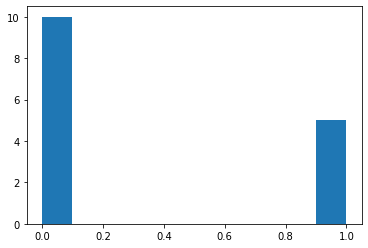

In [32]:
import matplotlib.pyplot as plt 

plt.hist(dataset_dict["test"]["label"])

In [7]:
dataset_dict["train"][0]["SLF_Seq"]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [8]:
amino_acid_one_hot.__name__

'amino_acid_one_hot'

In [83]:
from torch.nn import Module
import torch 
from typing import Any, List, Optional, Union


class AminoAcidsTokenizer(Module):
    """
    Transform for Sentence Piece tokenizer from pre-trained sentencepiece model

    Additiona details: https://github.com/google/sentencepiece

    :param sp_model_path: Path to pre-trained sentencepiece model
    :type sp_model_path: str

    Example
        >>> from torchtext.transforms import SentencePieceTokenizer
        >>> transform = SentencePieceTokenizer("spm_model")
        >>> transform(["hello world", "attention is all you need!"])
    """

    def __init__(self):
        super().__init__()

    def forward(self, input: Any) -> Any:
        """
        :param input: Input sentence or list of sentences on which to apply tokenizer.
        :type input: Union[str, List[str]]
        :return: tokenized text
        :rtype: Union[List[str], List[List(str)]]
        """
        if torch.jit.isinstance(input, List[str]):
            tokens: List[List[str]] = []
            for text in input:
                tokens.append(list(text))
            return tokens
        elif torch.jit.isinstance(input, str):
            return list(input)
        else:
            raise TypeError("Input type not supported")



In [86]:
from sis.dataset.transformer import AminoAcidsTokenizer

In [97]:
from datasets import load_dataset, Array2D
from functools import partial
import torchtext.transforms as T
from sis.constant import BASE_AMINO_ACIDS
from sis.dataset import build_vocab_from_alphabet_dict
from sis.dataset.transformer import AminoAcidsTokenizer

class sis_dataset(object):
    def __init__(self, SLF_max_length=420, SRnase_max_length=230, alphabet = BASE_AMINO_ACIDS, root_dir = "../data/total_data.csv", test_size=0.2):
        self.aa_vocab = build_vocab_from_alphabet_dict(alphabet)

        self.SLF_transform = T.Sequential(
            AminoAcidsTokenizer(),
            T.VocabTransform(self.aa_vocab),
            T.Truncate(SLF_max_length),
            T.ToTensor(self.aa_vocab["<pad>"]),
            T.PadTransform(SLF_max_length, pad_value=self.aa_vocab["<pad>"]),

        )
        self.SRnase_transform = T.Sequential(
            AminoAcidsTokenizer(),
            T.VocabTransform(self.aa_vocab),
            T.Truncate(SRnase_max_length),
            T.ToTensor(self.aa_vocab["<pad>"]),
            T.PadTransform(SRnase_max_length, pad_value=self.aa_vocab["<pad>"]),
        )

        self.test_size = test_size
        self.data_dir = root_dir
        self.dataset_dict = self._load()
    
    def _load(self):
        dataset_dict = load_dataset("csv", data_files=self.data_dir)

        dataset = dataset_dict["train"]

        #step1 preprocessing

        preprocessing_partial = partial(self.preproces ,SLF_transform = self.SLF_transform, SRnase_transform= self.SRnase_transform)

        dataset = dataset.map(preprocessing_partial, num_proc=4)

        # step2 to torch type
        selected_columns = ["SLF_Seq_token", "SRnase_Seq_token", "label"]

        dataset = dataset.with_format(type="torch",
        columns= selected_columns,
        output_all_columns=True
        )

        # step3 train_test_split
        dataset_dict = dataset.train_test_split(test_size=self.test_size, seed=20)
        return dataset_dict
    @staticmethod
    def preproces(item, SLF_transform, SRnase_transform):

        # use label:-1 data or not , 0 meas use while 1 means do not use 
        item["label"] = 0 if item["label"] == -1 else item["label"] 

        # tokenize
        item["SLF_Seq_token"] = SLF_transform(item["SLF_Seq"])
        item["SRnase_Seq_token"] = SRnase_transform(item["SRnase_Seq"]) 
        
        return item 


In [98]:
a = sis_dataset()
a.dataset_dict["train"][0]

Using custom data configuration default-ff972ea265b6b80a
Reusing dataset csv (/home/xutingfeng/.cache/huggingface/datasets/csv/default-ff972ea265b6b80a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

#0:   0%|          | 0/19 [00:00<?, ?ex/s]

#1:   0%|          | 0/19 [00:00<?, ?ex/s]

#2:   0%|          | 0/18 [00:00<?, ?ex/s]

#3:   0%|          | 0/18 [00:00<?, ?ex/s]

{'label': tensor(0),
 'SLF_Seq_token': tensor([12, 10, 11, 21, 17, 10,  5, 21, 10, 12,  2,  4, 16,  9,  9, 12, 10, 11,
         14, 15,  4, 19,  6,  9, 21,  9, 11, 11, 16, 11, 14, 19, 10, 11, 11, 11,
         16,  6, 16,  3, 19, 17, 10, 17,  3, 21, 18, 11,  9, 15, 17, 17, 18,  6,
          9, 13,  9,  8, 11,  4, 16, 18, 18, 18, 17,  5,  4,  5, 21,  9, 11,  6,
         10, 16, 17,  6, 10,  5,  4, 19,  5, 17, 21, 10,  7,  9,  6, 17,  6, 21,
         17, 17,  8, 13,  4,  4,  7,  4, 11, 13, 17,  9,  6, 14,  4, 11,  4, 19,
         14, 13, 12, 18, 17, 11, 21, 17,  9,  4, 21,  4, 10,  9,  9,  7, 14,  3,
          8,  7, 11,  9,  2, 19, 12,  4, 17, 16, 17, 18,  9, 11,  6, 13, 14, 17,
         18, 16, 10, 21, 16, 11, 11, 14, 17, 17, 14,  6,  7,  9, 14, 10,  7, 21,
         21, 16, 17,  9,  4, 17,  7,  7,  6,  7,  6,  4, 17, 19, 19, 13,  4, 21,
         10, 19,  6, 16,  9, 17,  4, 19, 21, 18,  5,  4, 16, 21,  7, 21, 14,  5,
          5,  7,  5, 16, 10, 19,  5, 19, 21,  5, 19,  7,  9,  4,  9, 20

In [99]:
a.dataset_dict["test"][2]

{'label': tensor(1),
 'SLF_Seq_token': tensor([12,  2, 13,  7,  9, 11, 10, 10, 11, 14,  5,  4, 11, 19,  6, 11,  9, 11,
         11, 18,  6, 14, 19, 10, 17, 11, 11, 16,  6, 10,  3,  9, 17, 10,  2, 20,
         17,  9, 11,  9, 15, 17, 18, 18,  6,  9, 13, 16,  8,  9, 13, 16, 10, 18,
         13, 18, 10,  2,  5,  6,  9, 11,  6, 10, 16, 17,  9, 10,  4,  5,  5,  5,
          5,  6,  9, 13,  9, 11, 17,  6,  6, 17,  7, 13,  4,  4, 19, 11, 13, 14,
         11,  6, 14,  4,  9,  4, 19, 17, 21, 12, 18, 17, 10,  3,  4,  3, 18,  6,
         18, 14, 11,  9,  7, 14,  3,  4,  7, 11,  9,  2, 11, 18,  4, 18,  9,  9,
         18,  9, 19, 11, 13, 14,  2, 18, 16, 13,  6, 16, 19, 11, 14, 14, 17, 14,
          6,  7,  3, 14, 10,  7, 21,  8, 16, 17, 19,  5,  7, 19,  7,  6,  7,  6,
          4, 18,  9, 17, 21, 21, 21, 10, 19, 19, 16,  9, 17,  5, 19, 21,  3,  5,
          5,  2,  4,  7, 21, 14,  7, 14, 10,  4, 17, 10,  9,  4, 19,  3,  4, 11,
         17, 18,  4, 17, 20, 16,  5, 11,  4,  8, 19, 15, 11, 14, 17,  9

In [16]:
from transformers import BertForMaskedLM, BertTokenizer, pipeline
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
# model = BertForMaskedLM.from_pretrained("Rostlab/prot_bert")
# unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer)
# unmasker('D L I P T S S K L V V [MASK] D T S L Q V K K A F F A L V T')


In [7]:

aa_vocab=build_vocab_from_alphabet_dict()

In [75]:
import torchtext.transforms as T
from sis.constant import BASE_AMINO_ACIDS
from sis.dataset import build_vocab_from_alphabet_dict

SLF_max_length = 220
SRnase_max_length = 400
alphabet = BASE_AMINO_ACIDS

aa_vocab = build_vocab_from_alphabet_dict()

SLF_transform = T.Sequential(
    T.VocabTransform(aa_vocab),
    T.Truncate(SLF_max_length),
    T.ToTensor(aa_vocab["<pad>"]),
    T.PadTransform(SLF_max_length, pad_value=aa_vocab["<pad>"]),

)
SRnase_transform = T.Sequential(
    T.VocabTransform(aa_vocab),
    T.Truncate(SRnase_max_length),
    T.ToTensor(aa_vocab["<pad>"]),
    T.PadTransform(SRnase_max_length, pad_value=aa_vocab["<pad>"]),
)


In [3]:
from sis.dataset import SISDataset
# a = sis_dataset()

# a

ModuleNotFoundError: No module named 'constant'

In [ ]:
a.dataset_dict